In [3]:
#https://uszipcode.readthedocs.io/index.html
!pip install uszipcode

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

#to set off the annoying copy warning
pd.set_option('mode.chained_assignment', None) #'warn'

In [9]:
from uszipcode import SearchEngine

In [11]:
search = SearchEngine()

Download C:\Users\migue\.uszipcode\simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [12]:
pd.set_option('display.max_columns', 100)

In [13]:
df = pd.read_csv(r'C:\Users\yosoy\Documents\ITU _ DATA MINING\B_Final_Assigment\100kCars.csv', ',')
df['state'] = 'NN'
df['elec_year'] = 0

C:\Users\migue\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\yosoy\\Documents\\ITU _ DATA MINING\\B_Final_Assigment\\100kCars.csv'

In [14]:
#df.head()

In [15]:
df = df.where(pd.notnull(df), None)
nullPercentage = df.isnull().mean() * 100

NameError: name 'df' is not defined

In [9]:
under_10_nulls = nullPercentage[nullPercentage < 10].index.values

In [10]:
under_10_nulls = np.append(under_10_nulls, 'city_fuel_economy')

In [11]:
df = df[under_10_nulls]

In [12]:
df.drop('description',inplace=True,axis=1)

In [13]:
#drop cars where is_new == true, as we are only interested in used cars
df = df[df.is_new != True]
df = df.reset_index(drop=True)

In [14]:
#adding state to cars dataframe in relation to dealer's zipcode
for row in range(len(df)):
    zip_car = df['dealer_zip'][row]
    zipcode = search.by_zipcode(zip_car)
    zipcode = zipcode.to_dict()
    df['state'][row] = zipcode['state']

## Missing values imputation (Anders code)

In [15]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [16]:
df = DataFrameImputer().fit_transform(df)

In [17]:
nullPercentage = df.isnull().mean() * 100

## Feature transformation (Anders code)

In [18]:
df["back_legroom"] = df["back_legroom"].str.split(" ",expand=True)[0].values
df["front_legroom"] = df["front_legroom"].str.split(" ",expand=True)[0].values
df["fuel_tank_volume"] = df["fuel_tank_volume"].str.split(" ",expand=True)[0].values
df["height"] = df["height"].str.split(" ",expand=True)[0].values
df["length"] = df["length"].str.split(" ",expand=True)[0].values
df["wheelbase"] = df["wheelbase"].str.split(" ",expand=True)[0].values
df["width"] = df["width"].str.split(" ",expand=True)[0].values
df["maximum_seating"] = df["maximum_seating"].str.split(" ",expand=True)[0].values

## Converting to numeric (Anders code)

In [19]:
columns_to_numeric = ["back_legroom",'front_legroom','fuel_tank_volume','height','length','width','maximum_seating']

In [20]:
df = df.replace('--',None)

In [21]:
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric)

In [22]:
pd.set_option('display.max_columns', 500)

In [23]:
#df.head()

## Processing US election data. 
We want the elected party per year per state


In [24]:
df_election = pd.read_csv(r'C:\Users\yosoy\Documents\ITU _ DATA MINING\B_Final_Assigment\1976-2020-president.csv', ',')
col_drop = ['state_ic', 'state_fips', 'state_cen', 'party_detailed', 'writein', 'totalvotes', 'version', 'notes']
df_election = df_election.drop(columns = col_drop)

In [25]:
df_states_hist_election = pd.DataFrame()
df_states_hist_election = df_election.loc[df_election.groupby(["year", "state"])["candidatevotes"].idxmax()]

years = pd.unique(df_states_hist_election['year'])
#states = pd.unique(df_states_hist_election['state_po'])

In [26]:
#most approx election year. f.ex. 2015 [2016] 2017 2018 -> 'elec_year' = 2016
for row in range(len(df)):
    car_year = df.iloc[row]['year']
    
    for i in range(len(years)):
        if (years[i] == car_year) or ((years[i]-1) == car_year) or ((years[i]+1) == car_year) or ((years[i]+2) == car_year):
            df['elec_year'][row] = years[i]

In [27]:
#df_states_hist_election.head()

# Merge both DataFrames

In [28]:
df = pd.merge(df,df_states_hist_election[['year','state_po','party_simplified']], how='left' , left_on=['state','elec_year'], right_on =['state_po','year'] )
df.drop(['year_y','state_po'],axis=1, inplace=True)
df.rename(columns={"year_x": "year"},inplace=True)
df.rename(columns={"party_simplified": "party"},inplace=True)

In [29]:
for i in range(len(df)):
    if df['party'][i] == 'REPUBLICAN':
        df['party'][i] = 1 #Republican
    else:
        df['party'][i] = 2 #Democrat

df['party'] = df['party'].astype(int)

In [30]:
#df.head()

------------------------------------------------------

# Preparing data frame with likelihoods and means per elec year per state

In [31]:
df_pptII = df.copy(deep=True)

In [32]:
df_pptII.columns

Index(['Unnamed: 0', 'vin', 'back_legroom', 'body_type', 'city',
       'daysonmarket', 'dealer_zip', 'engine_cylinders', 'engine_displacement',
       'engine_type', 'exterior_color', 'franchise_dealer', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'height', 'horsepower',
       'interior_color', 'is_new', 'latitude', 'length', 'listed_date',
       'listing_color', 'listing_id', 'longitude', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'price',
       'savings_amount', 'seller_rating', 'sp_id', 'sp_name', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'state',
       'elec_year', 'city_fuel_economy', 'party'],
      dtype='object')

In [33]:
col_to_drop = ['Unnamed: 0', 'vin', 'back_legroom', 'city','daysonmarket', 'dealer_zip', 'engine_cylinders', 'engine_displacement', 
               'exterior_color', 'franchise_dealer', 'front_legroom', 'height', 'interior_color', 'is_new', 'latitude', 'listed_date',
               'listing_color', 'listing_id', 'longitude', 'major_options', 'price', 'savings_amount', 'seller_rating', 'sp_id', 
               'sp_name', 'transmission_display', 'trimId', 'trim_name', 'wheel_system_display', 'wheelbase',  
               'transmission', 'wheel_system', 'width', 'length', 'fuel_type']

In [34]:
#delete unwanted columns
df_pptII = df_pptII.drop(columns = col_to_drop)
#df_pptII.head()

In [35]:
def cars_df_train_test(dataset):
    cars_df = pd.DataFrame()
    
    make_ocurrences = list(dataset['make_name'].value_counts()[:5].index)
    body_ocurrences = list(dataset['body_type'].value_counts()[:5].index)
    engine_ocurrences = list(dataset['engine_type'].value_counts()[:3].index)
    model_ocurrences = list(dataset['model_name'].value_counts()[:5].index)
    
    states = pd.unique(dataset['state']) #unique for a list of states
    
    for state in states:
        selected_state = dataset[dataset['state'] == state]
        state_years = pd.unique(selected_state['elec_year'])
        state_years.sort()
        
        for year in state_years:
            selected_state_year = selected_state[selected_state['elec_year'] == year]
            party = selected_state_year.iloc[0]['party']
            
            col_class = list(selected_state_year.columns)
            col_drop = ['year', 'state', 'elec_year', 'party']
            
            for i in range(len(col_drop)):
                col_d = (col_drop[i])
                del_index = col_class.index(col_d) 
                del col_class[del_index]

            #one structure at the time, then concat to the final dataframe
            df_temp = pd.DataFrame()
            df_temp['state'] = [state]
            df_temp['elec_year'] = [year]
            df_temp['party'] = [party]
            
            #check if is numerical (mean) or categorical (top 3 likelihood)
            temp_num = pd.DataFrame()
            temp_cat = pd.DataFrame()

            for col_name in col_class:
                if selected_state_year[col_name].dtype == 'O':
                    temp_cat = temp_cat.append(selected_state_year[col_name])
                else:
                    temp_num = temp_num.append(selected_state_year[col_name])

            temp_cat = temp_cat.T
            col_cat = list(temp_cat.columns)
            temp_num = temp_num.T
            col_num = list(temp_num.columns)

            #Cat > Now I need to take the row. get the most freq values and calculate likelihood.
            likelihood = pd.DataFrame()
            means = pd.DataFrame()

            for colName in col_cat:
                
                if colName == 'make_name':
                    value_counts = temp_cat[colName].value_counts().reindex(make_ocurrences, fill_value=0)
                    val_counts = pd.DataFrame(value_counts)
                    likelihood = val_counts.reset_index()
                    likelihood = likelihood.T
                    likelihood.columns = likelihood.iloc[0]
                    likelihood = likelihood.drop(labels='index', axis=0)
                    likelihood.reset_index(drop=True, inplace=True)
                    likelihood = likelihood.add_suffix(f" |{colName}") #colName
                    sum_like = float(likelihood.sum(axis=1))
                    for col in likelihood.columns:
                        like = 0
                        try:
                            like = likelihood.iloc[0][col] / sum_like
                            likelihood[col][0] = like
                        except:
                            likelihood[col][0] = like
                    df_temp = df_temp.join(likelihood)

                if colName == 'body_type':
                    value_counts = temp_cat[colName].value_counts().reindex(body_ocurrences, fill_value=0)
                    val_counts = pd.DataFrame(value_counts)
                    likelihood = val_counts.reset_index()
                    likelihood = likelihood.T
                    likelihood.columns = likelihood.iloc[0]
                    likelihood = likelihood.drop(labels='index', axis=0)
                    likelihood.reset_index(drop=True, inplace=True)
                    likelihood = likelihood.add_suffix(f" |{colName}") #colName
                    sum_like = float(likelihood.sum(axis=1))
                    for col in likelihood.columns:
                        like = 0
                        try:
                            like = likelihood.iloc[0][col] / sum_like
                            likelihood[col][0] = like
                        except:
                            likelihood[col][0] = like
                    df_temp = df_temp.join(likelihood)

                if colName == 'engine_type':
                    value_counts = temp_cat[colName].value_counts().reindex(engine_ocurrences, fill_value=0)
                    val_counts = pd.DataFrame(value_counts)
                    likelihood = val_counts.reset_index()
                    likelihood = likelihood.T
                    likelihood.columns = likelihood.iloc[0]
                    likelihood = likelihood.drop(labels='index', axis=0)
                    likelihood.reset_index(drop=True, inplace=True)
                    likelihood = likelihood.add_suffix(f" |{colName}") #colName
                    sum_like = float(likelihood.sum(axis=1))
                    for col in likelihood.columns:
                        like = 0
                        try:
                            like = likelihood.iloc[0][col] / sum_like
                            likelihood[col][0] = like
                        except:
                            likelihood[col][0] = like
                    df_temp = df_temp.join(likelihood)
               
                if colName == 'model_type':
                    value_counts = temp_cat[colName].value_counts().reindex(model_ocurrences, fill_value=0)
                    val_counts = pd.DataFrame(value_counts)
                    likelihood = val_counts.reset_index()
                    likelihood = likelihood.T
                    likelihood.columns = likelihood.iloc[0]
                    likelihood = likelihood.drop(labels='index', axis=0)
                    likelihood.reset_index(drop=True, inplace=True)
                    likelihood = likelihood.add_suffix(f" |{colName}") #colName
                    sum_like = float(likelihood.sum(axis=1))
                    for col in likelihood.columns:
                        like = 0
                        try:
                            like = likelihood.iloc[0][col] / sum_like
                            likelihood[col][0] = like
                        except:
                            likelihood[col][0] = like
                    df_temp = df_temp.join(likelihood)
                
                ''' #for a global non specific likelihood
                value_counts = temp_cat[colName].value_counts()[:2] #colName
                val_counts = pd.DataFrame(value_counts)
                likelihood = val_counts.reset_index()
                likelihood = likelihood.T
                likelihood.columns = likelihood.iloc[0]
                likelihood = likelihood.drop(labels='index', axis=0)
                likelihood.reset_index(drop=True, inplace=True)
                likelihood = likelihood.add_suffix(f" |{colName}") #colName
                sum_like = float(likelihood.sum(axis=1))
                for col in likelihood.columns:
                    like = 0
                    like = likelihood.iloc[0][col] / sum_like
                    likelihood[col][0] = like
                df_temp = df_temp.join(likelihood)
                '''  
            #if it is numerical calculate mean
            for colName in col_num:
                mean_col = temp_num[colName].mean()
                means[colName] = [mean_col]

            df_temp = df_temp.join(means)
            
            cars_df = cars_df.append(df_temp)
            cars_df = cars_df.fillna(0)
            cars_df = cars_df.round(2)
            cars_df = cars_df.loc[cars_df['elec_year']!=0] #year = 0 are just a few collectionables
            cars_df = cars_df.loc[cars_df.loc[:,'SUV / Crossover |body_type':'mileage'].sum(axis=1) != 0]
            
    return cars_df

In [36]:
cars_df = cars_df_train_test(df_pptII)

In [37]:
cars_df.tail()

,state,elec_year,party,SUV / Crossover |body_type,Sedan |body_type,Pickup Truck |body_type,Hatchback |body_type,Minivan |body_type,I4 |engine_type,V6 |engine_type,V8 |engine_type,Ford |make_name,Chevrolet |make_name,Toyota |make_name,Nissan |make_name,Honda |make_name,fuel_tank_volume,horsepower,maximum_seating,mileage,city_fuel_economy
0,OR,2012,2,0.25,0.00,0.75,0.00,0.0,0.33,0.67,0.00,1.00,0.0,0.00,0.0,0.0,29.30,295.00,5.50,103132.75,16.75
0,OR,2016,2,0.36,0.07,0.36,0.21,0.0,0.50,0.25,0.25,0.62,0.0,0.38,0.0,0.0,22.07,276.21,5.57,37725.86,22.86
0,OR,2020,2,0.71,0.14,0.00,0.14,0.0,0.71,0.14,0.14,0.40,0.2,0.40,0.0,0.0,17.73,211.50,5.75,58735.38,23.50
0,PR,2016,2,0.00,1.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,15.80,320.00,5.00,6903.00,22.00
0,HI,2016,2,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,20.00,283.00,7.00,28121.00,17.00


# Plotting Data to find tendencies, relations, clusters

In [38]:
import matplotlib.pyplot as plt

In [39]:
(cars_df.columns)

Index(['state', 'elec_year', 'party', 'SUV / Crossover |body_type',
       'Sedan |body_type', 'Pickup Truck |body_type', 'Hatchback |body_type',
       'Minivan |body_type', 'I4 |engine_type', 'V6 |engine_type',
       'V8 |engine_type', 'Ford |make_name', 'Chevrolet |make_name',
       'Toyota |make_name', 'Nissan |make_name', 'Honda |make_name',
       'fuel_tank_volume', 'horsepower', 'maximum_seating', 'mileage',
       'city_fuel_economy'],
      dtype='object')

In [40]:
#list of column names for plotting
body_type = ['SUV / Crossover |body_type', 'Sedan |body_type', 'Pickup Truck |body_type', 'Hatchback |body_type', 'Minivan |body_type']
engine_type = ['I4 |engine_type', 'V6 |engine_type', 'V8 |engine_type']
make_name = ['Ford |make_name', 'Chevrolet |make_name', 'Toyota |make_name', 'Nissan |make_name', 'Honda |make_name',]


In [41]:
cars_df.columns

Index(['state', 'elec_year', 'party', 'SUV / Crossover |body_type',
       'Sedan |body_type', 'Pickup Truck |body_type', 'Hatchback |body_type',
       'Minivan |body_type', 'I4 |engine_type', 'V6 |engine_type',
       'V8 |engine_type', 'Ford |make_name', 'Chevrolet |make_name',
       'Toyota |make_name', 'Nissan |make_name', 'Honda |make_name',
       'fuel_tank_volume', 'horsepower', 'maximum_seating', 'mileage',
       'city_fuel_economy'],
      dtype='object')

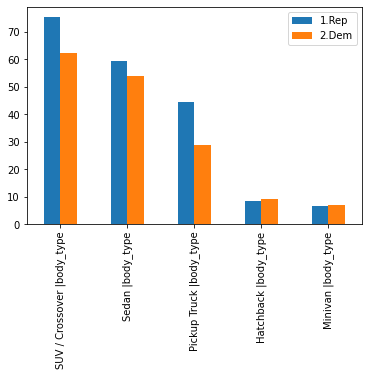

In [42]:
#relation between type of car and political party
btype_party = cars_df.groupby(['party'])[body_type].sum()
btype_party = pd.DataFrame(btype_party)
btype_party = btype_party.rename({'party': 'counts'}, axis=1)
btype_party = btype_party.reset_index()
del btype_party['party']

ax = btype_party.T.plot(kind='bar')
ax.legend(["1.Rep", "2.Dem"]);

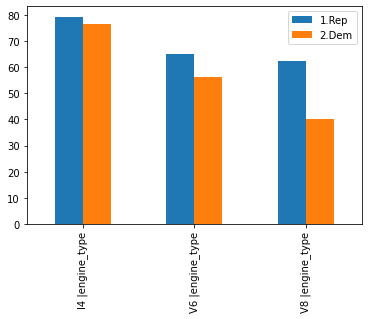

In [43]:
#relation between engine of car and political party
etype_party = cars_df.groupby(['party'])[engine_type].sum()
etype_party = pd.DataFrame(etype_party)
etype_party = etype_party.rename({'party': 'counts'}, axis=1)
etype_party = etype_party.reset_index()
del etype_party['party']

ax = etype_party.T.plot(kind='bar')
ax.legend(["1.Rep", "2.Dem"]);

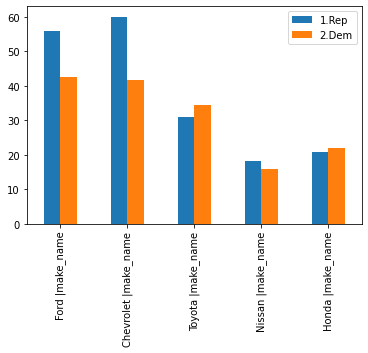

In [44]:
#relation between brand of car and political party
name_party = cars_df.groupby(['party'])[make_name].sum()
name_party = pd.DataFrame(name_party)
name_party = name_party.rename({'party': 'counts'}, axis=1)
name_party = name_party.reset_index()
del name_party['party']

ax = name_party.T.plot(kind='bar')
ax.legend(["1.Rep", "2.Dem"]);

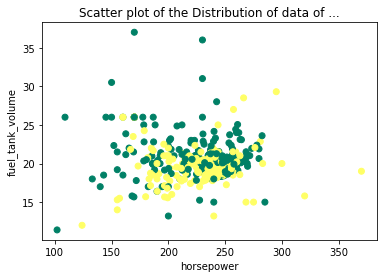

In [45]:
#max sitting and ... #different dot colors for party #millage relation to political party
plt.title('Scatter plot of the Distribution of data of ...')
plt.scatter(cars_df['horsepower'], cars_df['fuel_tank_volume'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('horsepower')
plt.ylabel('fuel_tank_volume')
plt.show()

Text(0, 0.5, 'fuel_tank_volume')

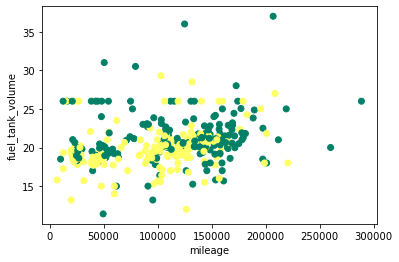

In [46]:
plt.scatter(cars_df['mileage'], cars_df['fuel_tank_volume'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('mileage')
plt.ylabel('fuel_tank_volume')

Text(0, 0.5, 'horsepower')

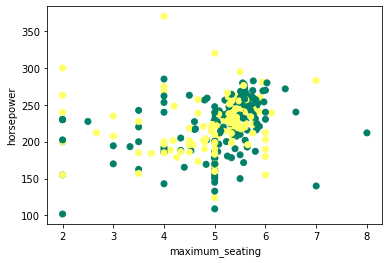

In [47]:
plt.scatter(cars_df['maximum_seating'], cars_df['horsepower'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('maximum_seating')
plt.ylabel('horsepower')

Text(0, 0.5, 'fuel_tank_volume')

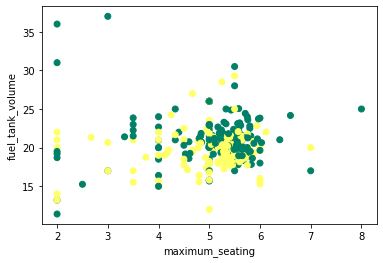

In [48]:
plt.scatter(cars_df['maximum_seating'], cars_df['fuel_tank_volume'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('maximum_seating')
plt.ylabel('fuel_tank_volume')

Text(0, 0.5, 'fuel_tank_volume')

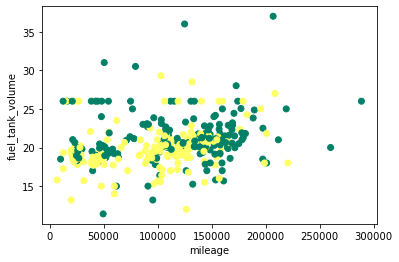

In [49]:
plt.scatter(cars_df['mileage'], cars_df['fuel_tank_volume'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('mileage')
plt.ylabel('fuel_tank_volume')

Text(0, 0.5, 'horsepower')

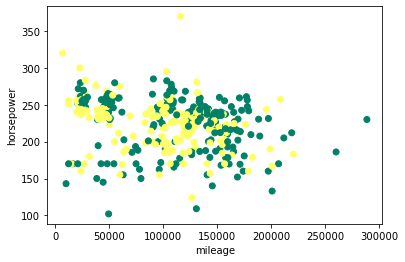

In [50]:
plt.scatter(cars_df['mileage'], cars_df['horsepower'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('mileage')
plt.ylabel('horsepower')

Text(0, 0.5, 'maximum_seating')

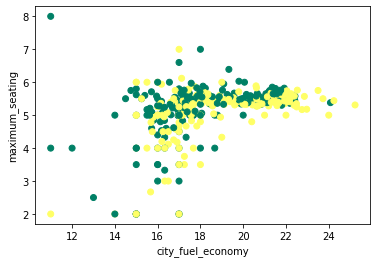

In [51]:
plt.scatter(cars_df['city_fuel_economy'], cars_df['maximum_seating'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('city_fuel_economy')
plt.ylabel('maximum_seating')

Text(0, 0.5, 'horsepower')

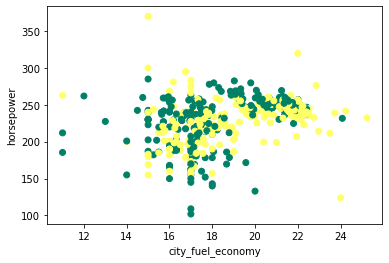

In [52]:
plt.scatter(cars_df['city_fuel_economy'], cars_df['horsepower'],\
            c=cars_df['party'], cmap=plt.cm.summer)
plt.xlabel('city_fuel_economy')
plt.ylabel('horsepower')

In [53]:
#political party % count per state
state_party = cars_df.groupby(['state'])['party'].value_counts(normalize=True)*100
state_party = pd.DataFrame(state_party)
state_party = state_party.rename({'party': '%'}, axis=1)

state_party

%
state party            
AL    1      100.000000
AR    1       83.333333
      2       16.666667
AZ    1       77.777778
      2       22.222222
...                 ...
WA    2      100.000000
WI    2       77.777778
      1       22.222222
WV    1      100.000000
WY    1      100.000000

[75 rows x 1 columns]

# Naive Bayes

In [54]:
#from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [55]:
X = cars_df.loc[:,'SUV / Crossover |body_type':]
y = cars_df['party']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [56]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))

# Use score method to get accuracy of the model
print('--------------------------------------------------------')
score = accuracy_score(y_test, y_pred)
print('Accuracy Score: ', score*100)
print('--------------------------------------------------------')

Number of mislabeled points out of a total 117 points : 49
--------------------------------------------------------
Accuracy Score:  58.119658119658126
--------------------------------------------------------


# Perceptron

In [57]:
from sklearn.linear_model import Perceptron

In [58]:
#separate features and target
X = cars_df.loc[:,'SUV / Crossover |body_type':]
y = cars_df['party'] 
#and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
#implementing Perceptron
ppn = Perceptron(random_state=True)
ppn.fit(X_train,y_train)

y_pred = ppn.predict(X_test)

In [60]:
#messuare performance
print('--------------------------------------------------------')
score = accuracy_score(y_test, y_pred)
print('Accuracy Score: ', score*100)
print('--------------------------------------------------------')

--------------------------------------------------------
Accuracy Score:  54.700854700854705
--------------------------------------------------------


-------------------------

what if we use categorical Naive Bayes, and test and train our data filtering per state (throughout all years)

# Naive Bayes > Categorical

In [61]:
df_cars_NB = df.copy(deep=True)

In [62]:
#Prepare dataframe for Naive Bayes
col_to_drop = list(df_cars_NB.columns)
col_keep = ['year','state','party','elec_year','body_type', 'engine_type', 'make_name','front_legroom','fuel_tank_volume','fuel_type','horsepower','maximum_seating', 'transmission']

for i in range(len(col_keep)):
    col_k = (col_keep[i])
    del_index = col_to_drop.index(col_k) 
    del col_to_drop[del_index]

#delete unwanted columns
df_cars_NB = df_cars_NB.drop(columns = col_to_drop)

from https://towardsdatascience.com/naive-bayes-classifier-how-to-successfully-use-it-in-python-ecf76a995069

In [63]:
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
from sklearn.naive_bayes import CategoricalNB

In [64]:
def classify_only_state(state, dataset):
    selected_state = dataset[dataset['state'] == state]
    
    # Bin continuous vairbales into 20% quantiles
    #selected_state['city_fuel_economy_qt'] = pd.qcut(selected_state['city_fuel_economy'].rank(method='first'), 5, labels=['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20'])
    selected_state['fuel_tank_volume_qt'] = pd.qcut(selected_state['fuel_tank_volume'].rank(method='first'), 5, labels=['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20'])
    selected_state['horsepower_qt'] = pd.qcut(selected_state['horsepower'].rank(method='first'), 5, labels=['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20'])
    selected_state['maximum_seating_qt'] = pd.qcut(selected_state['maximum_seating'].rank(method='first'), 5, labels=['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20'])
    
    # Select data for modeling
    X = selected_state[['transmission', 'body_type', 'engine_type', 'fuel_tank_volume_qt', 'fuel_type', 'horsepower_qt', 'make_name','maximum_seating_qt']]
    y = selected_state['party'].values
    y = y.astype(int)

    # Encode categorical variables
    enc = OrdinalEncoder()
    X = X.astype(str)
    X = enc.fit_transform(X)
    
    return X, y, selected_state #check y_test to see what you get.

In [65]:
def clssify_state_NB(state, dataset): #(X, y, X_test, selected_state):
    X, y, selected_only_state = classify_only_state(state, dataset) #trains the system only per state throughout the years
    
    #split train test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    clf = CategoricalNB()
    clf.fit(X_train, y_train)
    
    clf_pred = clf.predict(X_test)
    y_pred = clf.predict(X_test)
    clf_pred = pd.DataFrame(clf_pred)
    
    total_test = selected_only_state['party'].value_counts()
    pred_total_test = clf_pred.value_counts()
    
    pred_total_rep = (pred_total_test[1]*100) / len(total_test)
    pred_total_dem = (pred_total_test[2]*100) / len(total_test)
    
    if selected_only_state.iloc[0]['party'] == 1:
        state_party = 'Republican'
    else:
        state_party = 'Democrat'
    
    if pred_total_rep > pred_total_dem:
        pred_state_party = 'Republican'
    else:
        pred_state_party = 'Democrat'
        
    return state_party, pred_state_party, y_pred, y_test

In [66]:
electionStates = pd.unique(df_cars_NB['state'])

avg_calc = [0] #for the len() in accuracy average, we need to rest this position

for state in electionStates:
    try:
        state_party, pred_state_party, y_pred, y_test = clssify_state_NB(state, df_cars_NB)
        print('--------------------------------------------------------')
        score = accuracy_score(y_test, y_pred)
        avg_calc = np.append(avg_calc, score)
        print(f'State: {state} | Accuracy Score: {score*100}')
        printprint('--------------------------------------------------------')
    except:
        continue

print('--------------------------------------------------------------------')
print(f'accuracy average: {(avg_calc.sum()/(len(avg_calc)-1))*100}')

--------------------------------------------------------
State: IN | Accuracy Score: 89.16256157635468
--------------------------------------------------------
State: VA | Accuracy Score: 95.02164502164501
--------------------------------------------------------
State: LA | Accuracy Score: 99.47368421052632
--------------------------------------------------------
State: MO | Accuracy Score: 100.0
--------------------------------------------------------
State: CA | Accuracy Score: 99.4535519125683
--------------------------------------------------------
State: PA | Accuracy Score: 61.55115511551155
--------------------------------------------------------
State: NC | Accuracy Score: 91.26559714795009
--------------------------------------------------------
State: TN | Accuracy Score: 97.75280898876404
--------------------------------------------------------
State: CO | Accuracy Score: 93.8375350140056
--------------------------------------------------------
State: GA | Accuracy Score: 66

# --------the-----end-----miguel.